In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [34]:
train_dataframe = pd.read_csv("/kaggle/input/titanic/train.csv")
train_dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
test_dataframe = pd.read_csv("/kaggle/input/titanic/test.csv")
test_dataframe.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
# Replace categorical values
pd.set_option('future.no_silent_downcasting', True)
train_dataframe["Sex"] = train_dataframe["Sex"].replace({'male': 0, 'female': 1})
test_dataframe["Sex"] = test_dataframe["Sex"].replace({'male': 0, 'female': 1})

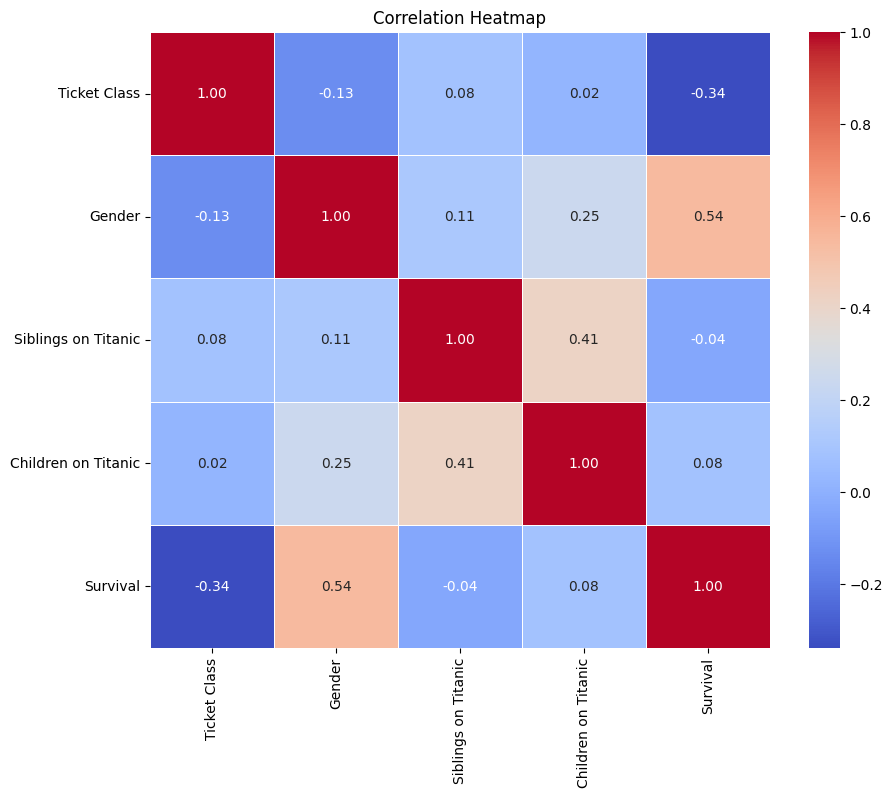

In [37]:
# VISUALIZING co-relation among features in training data
graph_train = pd.DataFrame({
    "Ticket Class": train_dataframe['Pclass'],
    "Gender": train_dataframe['Sex'],
    "Siblings on Titanic": train_dataframe['SibSp'],
    "Children on Titanic": train_dataframe['Parch'],
    "Survival": train_dataframe['Survived']
})

corr = graph_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

Index(['Ticket Class', 'Gender', 'Siblings on Titanic', 'Children on Titanic',
       'Survival'],
      dtype='object')


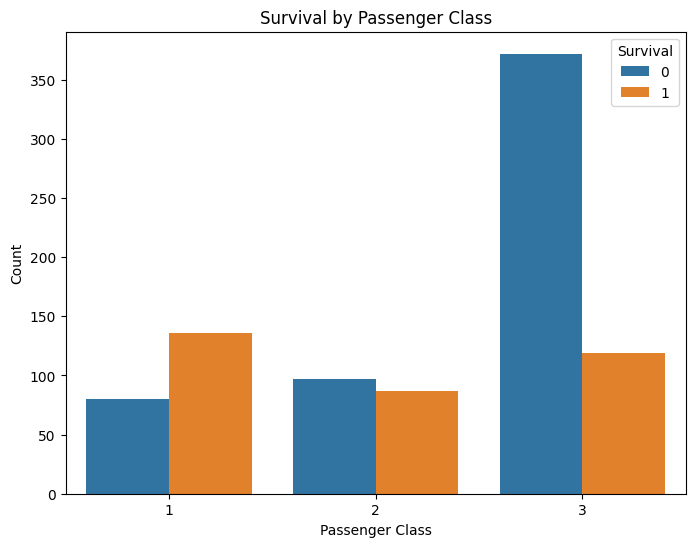

In [38]:
print(graph_train.columns)
plt.figure(figsize=(8, 6))
sns.countplot(x='Ticket Class', hue='Survival', data=graph_train)
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

In [39]:
# Create a proper training DataFrame
proper_train = pd.DataFrame({
    "X1": train_dataframe['Pclass'],
    "X2": train_dataframe['Sex'],
    "X3": train_dataframe['SibSp'],
    "X4": train_dataframe['Parch'],
    "label": train_dataframe['Survived']
})
# Create a proper testing DataFrame
proper_test = pd.DataFrame({
    "X1": test_dataframe['Pclass'],
    "X2": test_dataframe['Sex'],
    "X3": test_dataframe['SibSp'],
    "X4": test_dataframe['Parch'],
})

In [40]:
# Convert TRAINING DataFrame columns to NumPy arrays first, then to tensors
X1_train_array = proper_train['X1'].values
X2_train_array = proper_train['X2'].values
X3_train_array = proper_train['X3'].values
X4_train_array = proper_train['X4'].values
label_train_array = proper_train['label'].values


X1_train_array = X1_train_array.astype(np.float32)
X2_train_array = X2_train_array.astype(np.float32)
X3_train_array = X3_train_array.astype(np.float32)
X4_train_array = X4_train_array.astype(np.float32)
label_train_array = label_train_array.astype(np.float32)

X1_train_tensor = torch.tensor(X1_train_array, dtype=torch.float32)
X2_train_tensor = torch.tensor(X2_train_array, dtype=torch.float32)
X3_train_tensor = torch.tensor(X3_train_array, dtype=torch.float32)
X4_train_tensor = torch.tensor(X4_train_array, dtype=torch.float32)
label_train_tensor = torch.tensor(label_train_array, dtype=torch.float32)
label_train_tensor = label_train_tensor.to(device)

In [41]:

# Convert TESTING DataFrame columns to NumPy arrays first, then to tensors
X1_test_array = proper_test['X1'].values
X2_test_array = proper_test['X2'].values
X3_test_array = proper_test['X3'].values
X4_test_array = proper_test['X4'].values


X1_test_array = X1_test_array.astype(np.float32)
X2_test_array = X2_test_array.astype(np.float32)
X3_test_array = X3_test_array.astype(np.float32)
X4_test_array = X4_test_array.astype(np.float32)



X1_test_tensor = torch.tensor(X1_test_array, dtype=torch.float32)
X2_test_tensor = torch.tensor(X2_test_array, dtype=torch.float32)
X3_test_tensor = torch.tensor(X3_test_array, dtype=torch.float32)
X4_test_tensor = torch.tensor(X4_test_array, dtype=torch.float32)


In [42]:
# Combine TRAIN features into a single tensor
features_train_tensor = torch.stack((X1_train_tensor, X2_train_tensor, X3_train_tensor, X4_train_tensor), dim=1)
features_train_tensor = features_train_tensor.to(device)
# Combine TEST features into a single tensor
features_test_tensor = torch.stack((X1_test_tensor, X2_test_tensor, X3_test_tensor, X4_test_tensor), dim=1)

In [43]:
# Custom dataset class
class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [44]:
# Create TRAIN dataset and dataloader
train_dataset = TitanicDataset(features_train_tensor, label_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape)
print(train_labels_batch.shape)

torch.Size([8, 4])
torch.Size([8])


In [45]:
# Model
class ModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shapes: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shapes)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [46]:
model_1 = ModelV1(input_shape=4,
                  hidden_units=64,
                  output_shapes=1).to(device)


loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc


In [49]:

epochs = 2001
# Building training and evaluation loop
for epoch in range(epochs):

    if epoch % 200 == 0:
        print(f"\n\n\nEpoch: {epoch}")
    
    ###TRAINING
    train_loss = 0

    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
    
        model_1.train()
    
        # 1.forward pass
        y_logits = model_1(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
    
        # 2.Calculate the loss
        loss = loss_fn(y_logits, y)
        train_loss += loss  #accumalates training loss
        acc = accuracy_fn(y_true=y,
                          y_pred=y_pred)
    
        # 3.optimizer zero grad
        optimizer.zero_grad()
    
        # 4.Loss Backward (backpropagation)
        loss.backward()
    
        # 5.optimizer step step step(gradient descent)
        optimizer.step()

        if batch % 8 == 0 and epoch % 200 == 0:
            print(f'Looked at: {batch * 8}/{len(train_dataloader.dataset)} samples. | Loss: {loss:.5f} | Acc: {acc:.2f}%')

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)
    if epoch % 200 == 0:
        print(f"\nAverage Train Loss in Epoch {epoch}: {train_loss:.4f}")
    #Print out whats happening





Epoch: 0
Looked at: 0/891 samples. | Loss: 0.36808 | Acc: 75.00%
Looked at: 64/891 samples. | Loss: 0.17726 | Acc: 100.00%
Looked at: 128/891 samples. | Loss: 0.29803 | Acc: 87.50%
Looked at: 192/891 samples. | Loss: 0.65623 | Acc: 62.50%
Looked at: 256/891 samples. | Loss: 0.33160 | Acc: 87.50%
Looked at: 320/891 samples. | Loss: 0.34576 | Acc: 87.50%
Looked at: 384/891 samples. | Loss: 0.38901 | Acc: 75.00%
Looked at: 448/891 samples. | Loss: 0.40226 | Acc: 87.50%
Looked at: 512/891 samples. | Loss: 0.67400 | Acc: 75.00%
Looked at: 576/891 samples. | Loss: 0.17024 | Acc: 100.00%
Looked at: 640/891 samples. | Loss: 0.47308 | Acc: 87.50%
Looked at: 704/891 samples. | Loss: 0.46199 | Acc: 87.50%
Looked at: 768/891 samples. | Loss: 0.69494 | Acc: 75.00%
Looked at: 832/891 samples. | Loss: 0.52763 | Acc: 75.00%

Average Train Loss in Epoch 0: 0.4558



Epoch: 200
Looked at: 0/891 samples. | Loss: 0.22611 | Acc: 100.00%
Looked at: 64/891 samples. | Loss: 0.51895 | Acc: 75.00%
Looked at:

In [50]:
# Make prediction
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(features_test_tensor.to(device))



y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)
y_preds_numpy = y_preds.to(torch.int32)
y_preds_numpy = y_preds_numpy.squeeze()
y_preds_numpy = y_preds_numpy.cpu()

In [51]:
print(y_preds_numpy[:10])

tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=torch.int32)


In [52]:
output = pd.DataFrame({'PassengerId': test_dataframe.PassengerId, 'Survived': y_preds_numpy})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
